# Advanced Lane Finding Project
### The goals / steps of this project are the following:

#### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
#### Apply a distortion correction to raw images.
#### Use color transforms, gradients, etc., to create a thresholded binary image.
#### Apply a perspective transform to rectify binary image ("birds-eye view").
#### Detect lane pixels and fit to find the lane boundary.
#### Determine the curvature of the lane and vehicle position with respect to center.
#### Warp the detected lane boundaries back onto the original image.
#### Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Camera Calibration

### 1. Have the camera matrix and distortion coefficients been computed correctly and checked on one of the calibration images as a test?

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the
world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are
the same for each calibration image. Thus, objp is just a replicated array of coordinates, and objpoints
will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.
imgpoints will be appended with the (x, y) pixel position of each of the corners in the image plane with
each successful chessboard detection

I then used the output objpoints and imgpoints to compute the camera calibration and distortion
coefficients using the cv2.calibrateCamera() function. I applied this distortion correction to the test
image using the cv2.undistort() function and obtained this result:

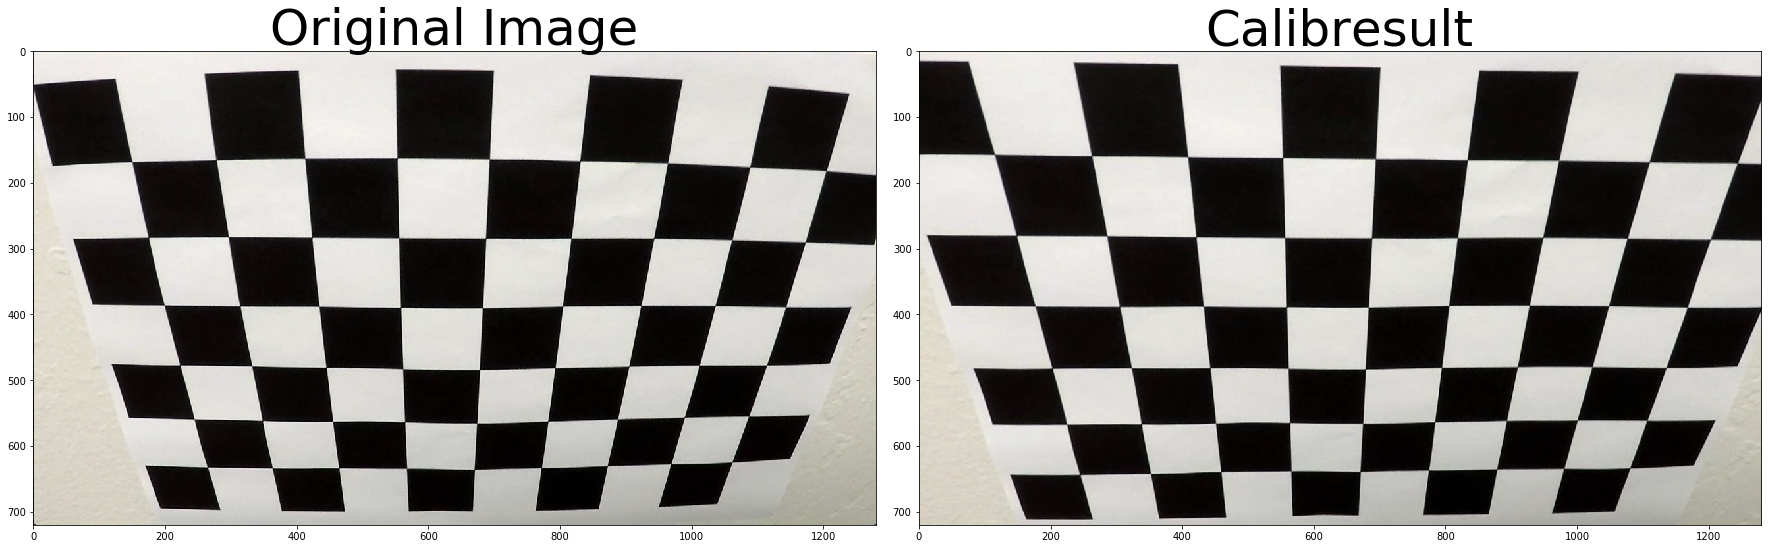

## Pipeline (single images)

### 1. Provide an example of a distortion-corrected image.

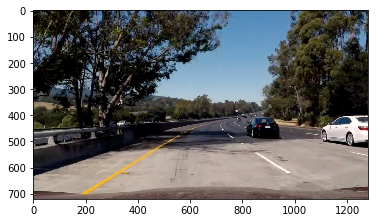

## Image offset

In [1]:
# function to calculate offset
# how far is the center of the lane from the center of the image
def center_offset(binary_warped, left_fit, right_fit):
    
    xm_per_pix = 3.7/700
    
    # image midpoint
    img_mid = binary_warped.shape[1] // 2
    
    # image height
    h = binary_warped.shape[0]
    
    if left_fit is not None and right_fit is not None:
        l = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        r = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        
        center = (l + r) / 2
        offset = (img_mid - center) * xm_per_pix
        
    return offset

### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

I used a combination of color and gradient thresholds to generate a binary image. Here's an example of my output for this step.

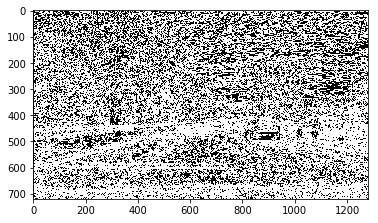

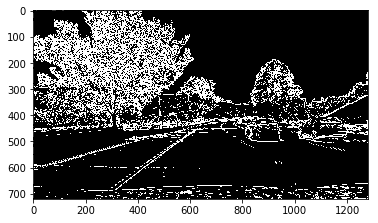

### All images can be found in output folders. And i skip those there and dive into discussion

#### Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

i made mistakes in almost every steps. I fixed most of them. I still have some questions. 
1. How to intergre this algorithm with real or virtual car? i dont know how to use customize search. Since if i need to use it, i need to know left_fit and right_fit. So i need to put slide_window before customized search. Buf by doing this, pipeline need to process slide_window every time, which makes no different. 
2. Can you give me some challenge images, like road image missing single lane so i can test algorithm with image rather than video? video takes too much time. Same for harder challenge images.
3. when lane disappear or change dramatically, my pipeline would fail.
4. i notice that green area stay still all the time. The ideal case is it changes when lane changes. So i need to do something with src and dst points. i also need to deal with lane missing and dramatic change

# Upgrade for few things

1. I clarified misunderustanding between left_fit and left_fitx. It turns out left_fitx is not as important as left_fit. i understand left_fit is key to write correction mechnism function.

In [1]:
#Aid for correction mech
class Line:
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [] 
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    
    def use_good_fit(self, fit, idx):
        
        if not fit is None:
            
            if not self.best_fit is None:
                self.diffs = abs(fit - self.best_fit)
            # making sure difference in fit coefficients between last and new fits greater than threshold 
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False      
            else:
                #if detected, add to current_fit
                self.detected = True
                self.px_count = np.count_nonzero(idx)
                self.current_fit.append(fit)
                #get rid of top 10 oldest fit
                if len(self.current_fit) > 5:
                    self.current_fit = self.current_fit[len(self.current_fit)-10:]
                self.best_fit = np.average(self.current_fit, axis=0)
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            else:
                self.best_fit = np.average(self.current_fit, axis=0)   

In [3]:
## couple questions 
## how do we take care of first input(image)? it's inside of pipeline or outside? if inside, it's quite ineffectient 
## problem i got here is more like chicken first or eggs first
## My solution is to check left_fit and right_fit. if any of them detected, it means we can use customized search
## that being said, i need initilization points for customized search, otherwise i couldnt use it
def pipeline(images):
    
    threshold_image = threshold_images(images)
    binary_warped = perspective(threshold_image)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    nwindows = 9
    margin  = 50
    minpix   = 50
 
 # Thanks to jeremy-shannon @Github, his code helps me understand chicken first or egg first confusion
 # Code below is solution and it really inspires me.

    if not right_lane.detected or not left_lane.detected:
        left_fit, right_fit, left_lane_inds, right_lane_inds = slide_windows_fit(binary_warped, nwindows, margin, minpix)   
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = customized_search(binary_warped, left_lane.best_fit, right_lane.best_fit)
    
    # By using this below, we can get the best fit   
    left_lane.use_good_fit(left_fit, left_lane_inds)
    right_lane.use_good_fit(right_fit, right_lane_inds)
    
    # if best fit found, draw on images
    if not left_lane.best_fit is None and not right_lane.best_fit is None:
        result = combine(binary_warped, images, left_lane.best_fit, right_lane.best_fit)
        offset = center_offset(binary_warped, left_lane.best_fit, right_lane.best_fit)
        
        left_curverad_real, right_curverad_real = measure_curvature_real(left_lane.best_fit, right_lane.best_fit, ploty)
         
        cv2.putText(result,str(left_curverad_real), (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
        cv2.putText(result,str(right_curverad_real), (100, 155), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
        cv2.putText(result,str(offset), (100, 205), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return result

### Basic Logic for Line (correction mechnism)

For every new image, we obtain new left_fit and right_fit:
    we need to know if it's good fit by setting up threshold.
    if satisfied, we store it in container:
        we computer the best_fit by averaging top 5/10 values